# Getting images from AOI in Kenya
In this notebook ad based on the data we have from DL hub website for the regios that had attacks, we are going to to do the follwoing:

- Load the geoJson gile vontains the the AOI as oints
- Draw a polygon around the points. This will be our image.
- Get images from Sentinel-2 and download them.

In [19]:
import geopandas as gpd
import numpy as np
import folium
import rasterio
import geemap
from functools import reduce
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
from functools import reduce
from shapely.geometry import shape
import numpy as np
import math
import fiona
import boto3

# To add days to a certain date
from datetime import datetime  
from datetime import timedelta 

%matplotlib inline

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

# Authenticates and initializes Earth Engine
import ee

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [20]:
# Read the geoJson file
file_path = 'D:/hub_data_kenya_latest_attacks.geojson'
kenya_aoi = gpd.read_file(file_path)


In [26]:
kenya_aoi

,Unnamed: 0,X,Y,OBJECTID_left,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,...,index_right,OBJECTID_right,AREA,PERIMETER,COUNTY3_,COUNTY3_ID,COUNTY,Shape_Leng,Shape_Area,geometry
0,24675,37.350000,1.033333,24676,2020-01-27,08:57:00,2020-01-27,08:57:00,No,Late,...,5,6,1.713,8.311,7,6,Samburu,8.311013,1.713014,POINT (37.35000 1.03333)
1,24676,37.600000,0.683333,24677,2020-01-27,09:45:00,2020-01-27,09:45:00,No,Late,...,5,6,1.713,8.311,7,6,Samburu,8.311013,1.713014,POINT (37.60000 0.68333)
2,24677,37.433333,1.350000,24678,2020-01-27,11:06:00,2020-01-27,11:06:00,No,Late,...,5,6,1.713,8.311,7,6,Samburu,8.311013,1.713014,POINT (37.43333 1.35000)
3,24678,37.300000,0.866667,24679,2020-01-27,11:11:00,2020-01-27,11:11:00,No,Late,...,5,6,1.713,8.311,7,6,Samburu,8.311013,1.713014,POINT (37.30000 0.86667)
4,24682,37.666667,0.800000,24683,2020-01-27,11:59:00,2020-01-27,11:59:00,No,Late,...,5,6,1.713,8.311,7,6,Samburu,8.311013,1.713014,POINT (37.66667 0.80000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163,26126,34.955833,0.284722,26129,2020-03-06,00:00:00,2020-03-06,00:00:00,No,Early,...,13,14,0.243,4.089,15,14,Kakamega,4.089310,0.242844,POINT (34.95583 0.28472)
2164,26127,35.095833,0.803611,26130,2020-03-06,00:00:00,2020-03-06,00:00:00,No,Early,...,13,14,0.243,4.089,15,14,Kakamega,4.089310,0.242844,POINT (35.09583 0.80361)
2165,26165,34.932222,0.440556,26168,2020-03-08,00:00:00,2020-03-08,00:00:00,No,Early,...,13,14,0.243,4.089,15,14,Kakamega,4.089310,0.242844,POINT (34.93222 0.44056)
2166,26171,34.919444,0.407222,26174,2020-03-09,00:00:00,2020-03-09,00:00:00,No,Early,...,13,14,0.243,4.089,15,14,Kakamega,4.089310,0.242844,POINT (34.91944 0.40722)


<AxesSubplot:>

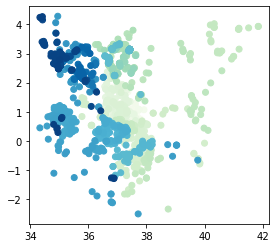

In [22]:
kenya_aoi.plot(cmap='GnBu')

In [23]:
# Let's get the dates from the dataframe and use it when extracting the images
dates_df = kenya_aoi[['STARTDATE', 'FINISHDATE', 'geometry']]


In [43]:
dates_df.STARTDATE.unique()

array(['2020-01-27', '2020-01-26', '2020-01-29', '2020-01-28',
       '2020-01-24', '2020-01-12', '2020-01-30', '2020-01-31',
       '2020-01-17', '2020-01-18', '2020-01-21', '2020-01-13',
       '2020-01-15', '2020-02-18', '2020-02-17', '2020-02-06',
       '2020-02-07', '2020-02-12', '2020-02-11', '2020-02-13',
       '2020-02-14', '2020-02-16', '2020-02-19', '2020-02-20',
       '2020-02-04', '2020-02-28', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-30', '2020-03-20', '2020-03-21',
       '2020-03-22', '2020-03-26', '2020-03-06', '2020-04-26',
       '2020-04-24', '2020-04-14', '2020-04-15', '2020-04-25',
       '2020-04-27', '2020-04-17', '2020-04-16', '2020-04-18',
       '2020-04-13', '2020-04-05', '2020-04-28', '2020-04-29',
       '2020-04-08', '2020-04-07', '2020-04-01', '2020-04-19',
       '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
       '2020-04-11', '2020-04-09', '2020-04-10', '2020-04-04',
       '2020-04-03', '2020-05-22', '2020-05-23', '2020-

Creat a mask to select dates within the harvesting season

In [58]:
# This is the harvest season in Kenya
start_date = '2020-06-30'
end_date = '2020-10-15'

In [59]:
mask = (dates_df['STARTDATE'] > start_date) & (dates_df['FINISHDATE'] < end_date)

In [60]:
df = dates_df.loc[mask]

In [75]:
len(df)

194

In [73]:
df.to_file('within_harvesting.geojson', driver='GeoJSON')

In [72]:
m = folium.Map([48.2, 16.4], zoom_start=10)
 
folium.Choropleth(
    df.geometry,
    line_weight=3,
    line_color='blue'
).add_to(m)
 
m

In [6]:
start_date=dates_df.STARTDATE.iloc[0] 
type(start_date)

str

In [20]:
# start the exportation job on GEE server for the preprocessed images
def exportImages(task_config, image, description):
    '''
    Takes task configuration and export images to google drive
    Parameters:
    task_config (Dictionary): the task configuration (folder (string), 
    fileNamePrefix (string), scale (int), region (ee.Geometry))
    image (ee.Image): The image to export
    description (string) : short description for the image
    '''
    # Export image to Google Drive
    task = ee.batch.Export.image.toDrive(image.toFloat(), description, **task_config)
    task.start()
    print("Exporting {}".format(description))
    return task

# Preprocess the images
def preprocessImage(image):
    '''
    takes an imageCollection sxtracted from EE and add extra bands to our selected image
    Parameters:
    imageCollection (ee.ImagCollection) : Image collection from EE
    threshold (float) : threshold to extract the ndi masks
    
    Return:
    image (ee.Image) : preprocessed image
    '''
    nir = image.select(['B8'])
    red = image.select(['B4'])
    blue = image.select(['B2'])
    green = image.select(['B3'])
    swir = image.select(['B11'])
    red_edge = image.select(['B8A'])
    
   
     # Set configration parameters for output image
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    #2.5 * (data_after[8] - data_after[4]) / ((data_after[8] + 6 * data_after[4] - 7.5 * data_after[2]) + 1)
    # Compute the EVI using an expression.
    evi = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR': nir,
      'RED': red,
      'BLUE': blue
    }).rename('EVI')
    
    # This function adds a band representing the image timestamp.
    #time_stamp = image.metadata('system:time_start').rename('TimeStamp')
    image = image.addBands([ndvi, evi]) 
    # Select the B bands
    return image


# Define the region of interest and start the exportation job
def exportData(region, rectangle, task_desc, folder_name, file_prefex, cloud_cover=10, start_date="2019-10-01", end_date="2019-12-15"):
    '''
    Esports an image to Google drive based on a givien region and rectangle 
    Parameters:
    region (string): The region of interest (2 square km)
    rectangle (list): The polygon around the region
    task_desc (str)
    '''  
    roi = ee.Geometry.Rectangle(rectangle)
    S2 = ee.ImageCollection("COPERNICUS/S2")
    
    # Read the roi
    # filter the images
    image = ee.ImageCollection(S2).filterBounds(roi)\
      .filterDate(start_date, end_date).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', cloud_cover).median()
    
   
    #regionArea = images.geometry().area()
    #regionAreaSqKm = images.geometry().area().divide(1e6).round().getInfo()
    #print("Area = {} km2".format(regionAreaSqKm))
    # Calculate the masks bands and add them as extra bands
    if image.bandNames() is None:
        return None        
    else:
        image = preprocessImage(image)

        description = task_desc  # set the output image filename
        #assetId = "users/rashagh22/Eth_pop_1"
        task_config = {
        'folder': folder_name,
        'fileNamePrefix' : file_prefex,
        'region': region,
        'scale': 10
        }
        # Export image to Google Drive
        task = exportImages(task_config, image, description)    
    
        return task
    
    
    

- Next we'll extract the ccordinates from our shapefile to feed them to our area calculater
- Calculate the area around our points (around 1.5 Km^2)

In [34]:
# Open geoJson with fiona and get all the lists of coordinates
point_path = file_path
points = fiona.open(point_path)
geoms = [ shape(feat["geometry"]) for feat in points]

# Here we have all our coordinates (points)
list_coordinates = [ list((geom.xy[0][0], geom.xy[1][0])) for geom in geoms ]
#print(list_coordinates[:5])
# Distances are measured in kilometers.
# Longitudes and latitudes are measured in degrees.
# Earth is assumed to be perfectly spherical.

earth_radius = 6271.0
degrees_to_radians = math.pi/180.0
radians_to_degrees = 180.0/math.pi

def change_in_latitude(kms):
    "Given a distance north, return the change in latitude."
    return (kms/earth_radius)*radians_to_degrees

def change_in_longitude(latitude, kms):
    "Given a latitude and a distance west, return the change in longitude."
    # Find the radius of a circle around the earth at given latitude.
    r = earth_radius*math.cos(latitude*degrees_to_radians)
    return (kms/r)*radians_to_degrees

def two_km_square(latitude, longitude):
    slat, nlat = latitude+change_in_latitude(-1.1025), latitude+change_in_latitude(1.1025)
    wlon = longitude+change_in_longitude(latitude,-1.1025)
    elon = longitude+change_in_longitude(latitude, 1.1025)
    return(nlat, wlon, slat, elon)

def main(lon, lat):
    '''First argument degrees longitude (E is positive, W negative)
        of the landslide location,
        second argument latitude (N positive, S negative),
        in decimal format(not minutes etc.)'''
    nlat, wlon, slat, elon = two_km_square(lat,lon)
    #print("(NLat:{:.4f},WLon:{:.4f}),(SLat:{:.4f},ELon:{:.4f});".format(nlat, wlon, slat, elon))
    #print("region = '[[{:.4f},{:.4f}], [{:.4f},{:.4f}], [{:.4f},{:.4f}], [{:.4f},{:.4f}]]', rectangle = [{:.4f},{:.4f},{:.4f},{:.4f}]".format(wlon,nlat,elon,nlat,wlon,slat,elon,slat, wlon,slat,elon,nlat))
    return nlat, wlon, slat, elon

#change these to longitude, latitude
# Calculate get 2 square km region for our coordinates
#regions_file = open("regions.txt","w")
list_regions = []
for item in list_coordinates[:]:
    x = item[0]
    y = item[1]

    # This will contain all aoi prepared and ready to preprocessed and exported
    list_regions.append(main(x, y))
print(len(list_regions))

2168


In [35]:
# Execute the export task (this will send the jobs to GEE and you'll get your images on Google drive)
i = 0
for item_region in list_regions:
    nlat, wlon, slat, elon = item_region
    region = "[[{:.4f},{:.4f}], [{:.4f},{:.4f}], [{:.4f},{:.4f}]]".format(wlon,nlat,elon,nlat,wlon,slat,elon,slat)
    rectangle =  [wlon,slat,elon,nlat]
    
    # Use this for the during/after dates since it is different for each county
    attack_start_date = datetime.strptime(dates_df.STARTDATE.iloc[i], '%Y-%m-%d')
    attack_end_date = datetime.strptime(dates_df.FINISHDATE.iloc[i], '%Y-%m-%d')
    
    #start_date=(attack_start_date - timedelta(15)).date()
    #end_date=(attack_start_date - timedelta(1)).date()
    
    #start_date=attack_start_date - timedelta(3)
    #end_date=attack_end_date + timedelta(3)
    
    start_date=attack_end_date + timedelta(1)
    end_date=attack_end_date + timedelta(15)
    
    # Cast date to string (This part needs to be more moduler)
    start_date = start_date.strftime('%Y-%m-%d')
    end_date = end_date.strftime('%Y-%m-%d')

    task = exportData(region, rectangle, "Kenya_aoi_Sentinel", "Kenya_AOI_after", "kenya_aoi_after",cloud_cover=10, start_date = start_date, end_date= end_date)
    i += 1

Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Keny

Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Keny

Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Keny

Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Keny

Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Keny

Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Keny

Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Keny

Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Kenya_aoi_Sentinel
Exporting Keny

In [33]:
# Check task status

task.status()

{'state': 'READY',
 'description': 'Kenya_aoi_Sentinel',
 'creation_timestamp_ms': 1608186432099,
 'update_timestamp_ms': 1608186432099,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'RL3WPYFMJJLHZUKLIEDCCMG5',
 'name': 'projects/earthengine-legacy/operations/RL3WPYFMJJLHZUKLIEDCCMG5'}